# WatChMaL: Bias Analysis
### Iñaki Erregue Álvarez-Buhilla

In [159]:
import uproot
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys
import h5py
import pandas as pd
from sklearn import metrics

In [160]:
sys.path.append('/home/ierregue/scratch/code7/')
import analysis.event_utils as ev

In [161]:
sys.path.append('/home/ierregue/scratch/code7/notebooks/utils')
from utils import *

## Load all the data

In [162]:
# TEST INDICES

idxs_path = '/home/ierregue/scratch/code7/notebooks/biases/data/IWCD_mPMT_Short_2_class_idxs_xps.npz'

idxs = np.load(idxs_path, allow_pickle=True)
test_idxs  = idxs['test_idxs']

In [163]:
# METADATA

data_path = "/project/rpp-blairt2k/machine_learning/data/IWCD_mPMT_Short/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"

h5_file = h5py.File(data_path, "r")
h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
h5_root_files = np.array(h5_file['root_files'])[test_idxs].squeeze()
h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()
h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()

towall = ev.towall(h5_positions, h5_angles)
dwall = ev.dwall(h5_positions)
momentum = ev.momentum(h5_energies, h5_labels)

In [189]:
# RESNET OUPUTS + RESNET BENCHMARK

output_base_path = '/home/ierregue/scratch/code7/notebooks/biases/data/uncertainties/'
# maybe onthe path for bm

uncertainties = np.load(output_base_path + 'uncertainties.npy')[:,0] # Choose one
probs = np.load(output_base_path + 'softmax.npy')
pred = np.load(output_base_path + 'predictions.npy')
bm_probs = np.load(output_base_path + 'bm_softmax.npy')
bm_pred = np.load(output_base_path + 'bm_predictions.npy')

In [190]:
# BUILD DF

data_matrix = np.vstack((test_idxs, h5_labels, pred, probs[:,1], bm_pred, bm_probs[:,1], uncertainties, towall, dwall, momentum, h5_energies, h5_angles[:,0], h5_angles[:,1]))
df = pd.DataFrame(data_matrix.T, columns=['id','label', 'pred', 'eprob', 'bm_pred', 'bm_eprob', 'uncertainty', 'towall', 'dwall', 'p', 'E', 'zen', 'azi'])
df.head()

,id,label,pred,eprob,bm_pred,bm_eprob,uncertainty,towall,dwall,p,E,zen,azi
0,2944634.0,0.0,0.0,0.300520,0.0,0.292756,0.089938,190.761574,64.608521,245.777585,245.777588,2.380216,-2.014716
1,2944635.0,0.0,0.0,0.185529,0.0,0.142284,0.125455,158.604782,99.009644,858.386823,858.386841,2.396345,-1.009569
2,2944636.0,0.0,0.0,0.134046,0.0,0.118797,0.092241,41.012970,30.859924,984.556023,984.556030,0.719032,-1.875060
3,2944637.0,0.0,1.0,0.637576,1.0,0.638758,0.030773,417.253355,121.900787,818.989202,818.989197,1.234110,1.671546
4,2944638.0,0.0,0.0,0.311224,0.0,0.301379,0.073516,78.351025,74.096588,60.207409,60.207409,1.387609,0.267695


## fiTQun comparison (vetos etc.)

## 0 - General Performance (Orginal vs. Time)

## 1 - Classes

In [166]:
label_dict = {'Gamma':0, 'Electron':1}

{'Gamma': 0, 'Electron': 1}
{'Gamma': 0, 'Electron': 1}


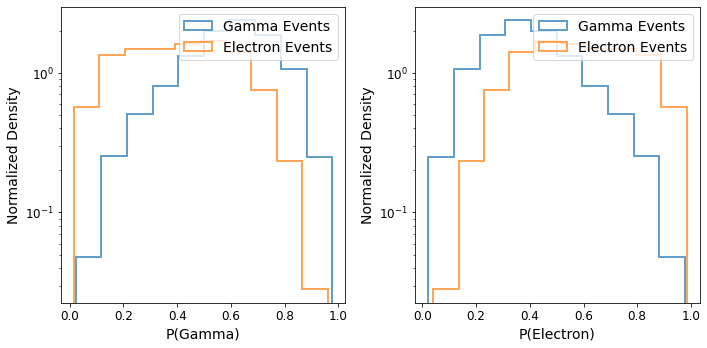

In [167]:
# Plot classifier likelihoods over different classes for events of a given particle type
plot_classifier_response(probs, df['label'].to_numpy(), list(label_dict.keys()), label_dict)

In [168]:
#plot_cm(df['labels'],df['pred'], list(label_dict.keys())

In [193]:
df_1 = df[['label','pred']].groupby('label').apply(lambda x: metrics.accuracy_score(x['label'],x['pred'])).to_frame(name='accuracy').reset_index()
df_2 = df[['label','uncertainty']].groupby('label').mean('uncertainty').reset_index()
df_3 = df_1.merge(df_2, on='label')
df_3

,label,accuracy,uncertainty
0,0.0,0.719832,0.058463
1,1.0,0.629530,0.045758


In [170]:
# more in the assigment

## 2 - Phase Space 

In [171]:
def electron_signal_eff(y_actual, y_hat):
    cm1 = metrics.confusion_matrix(y_actual, y_hat)
    TPR = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    return TPR

### 2.1 - Energy

In [172]:
#plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams.update({'font.size': 12})

In [173]:
# BINS

df['E_bins'] = pd.cut(df['E'], bins=np.arange(0,1050,50), labels=np.arange(0,1000,50))

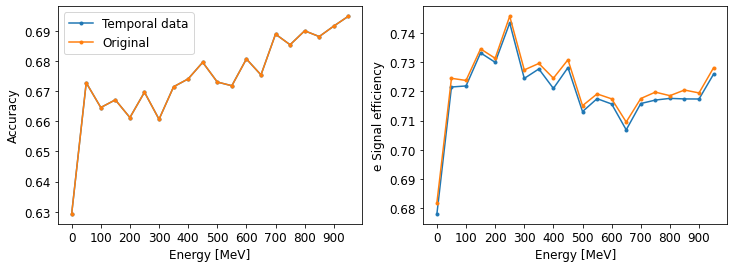

In [174]:
# Energy vs Accuracy and Signal eff

fig, axes = plt.subplots(ncols=2, figsize=(12,4), sharex=True)

bin_acc = df[['label','pred', 'E_bins']].groupby('E_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_acc = df[['label','bm_pred', 'E_bins']].groupby('E_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[0].errorbar(bin_acc[:,0], bin_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Temporal data')#yerr=bin_uncertainty[:,1]
axes[0].errorbar(bin_bm_acc[:,0], bin_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Original')
#axes[0].set_ylim(0,1)
axes[0].set_xticks(np.arange(0,1000,100))
axes[0].set_xlabel('Energy [MeV]')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

bin_ese = df[['label','pred', 'E_bins']].groupby('E_bins').apply(lambda x: electron_signal_eff(x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_ese = df[['label','bm_pred', 'E_bins']].groupby('E_bins').apply(lambda x: electron_signal_eff(x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[1].errorbar(bin_ese[:,0], bin_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1)#yerr=bin_uncertainty[:,1]
axes[1].errorbar(bin_bm_ese[:,0], bin_bm_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1)
#axes[1].set_ylim(0,1)
axes[1].set_xticks(np.arange(0,1000,100))
axes[1].set_xlabel('Energy [MeV]')
axes[1].set_ylabel('e Signal efficiency')
#axes[1].legend()

plt.show()

In [191]:
# Energy vs Uncertainty

bin_uncertainty = df[['uncertainty', 'E_bins']].groupby('E_bins').mean().reset_index().to_numpy()


fig, ax1 = plt.subplots()

ax1.errorbar(bin_uncertainty[:,0], bin_uncertainty[:,1], fmt='.-r', elinewidth=0.5, capsize=1)
ax1.set_ylim(0.1,0.4)
ax1.set_xticks(np.arange(0,1100,100))
ax1.set_xlabel('Energy')
ax1.set_ylabel('Uncertainty')

plt.show()

KeyError: "['E_bins'] not in index"

## 3 - Detector Geometry

### 3.1 - Distances

In [176]:
# BINS

df['d1_bins'] = pd.cut(df['towall'], bins=np.arange(0,1000,50), labels=np.arange(0,950,50))
df['d2_bins'] = pd.cut(df['dwall'], bins=np.arange(0,315,15), labels=np.arange(0,300,15))

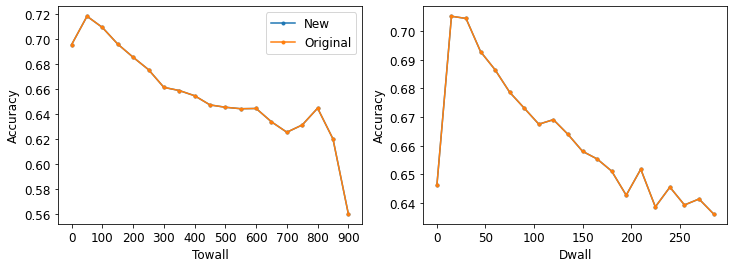

In [177]:
# Distances vs Accuracy

fig, axes = plt.subplots(ncols=2, figsize=(12,4))

bin_acc = df[['label','pred', 'd1_bins']].groupby('d1_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_acc = df[['label','bm_pred', 'd1_bins']].groupby('d1_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[0].errorbar(bin_acc[:,0], bin_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='New')#yerr=bin_uncertainty[:,1]
axes[0].errorbar(bin_bm_acc[:,0], bin_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Original')
#axes[0].set_ylim(0,1)
axes[0].set_xticks(np.arange(0,1000,100))
axes[0].set_xlabel('Towall')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

bin_acc = df[['label','pred', 'd2_bins']].groupby('d2_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_acc = df[['label','bm_pred', 'd2_bins']].groupby('d2_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[1].errorbar(bin_acc[:,0], bin_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='New')#yerr=bin_uncertainty[:,1]
axes[1].errorbar(bin_bm_acc[:,0], bin_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Original')
#axes[1].set_ylim(0,1)
axes[1].set_xticks(np.arange(0,300,50))
axes[1].set_xlabel('Dwall')
axes[1].set_ylabel('Accuracy')
#axes[1].legend()

plt.show()

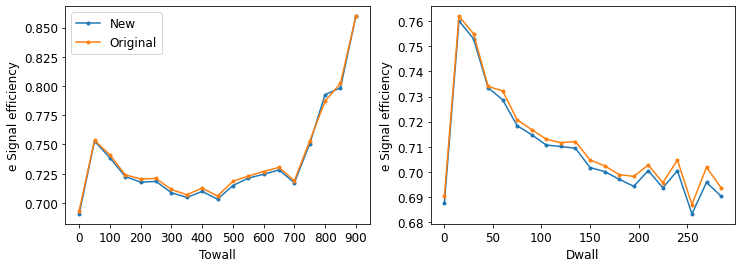

In [178]:
# Distances vs Signal eff

fig, axes = plt.subplots(ncols=2, figsize=(12,4))

bin_ese = df[['label','pred', 'd1_bins']].groupby('d1_bins').apply(lambda x: electron_signal_eff(x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_ese = df[['label','bm_pred', 'd1_bins']].groupby('d1_bins').apply(lambda x: electron_signal_eff(x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[0].errorbar(bin_ese[:,0], bin_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='New')#yerr=bin_uncertainty[:,1]
axes[0].errorbar(bin_bm_ese[:,0], bin_bm_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Original')
#axes[0].set_ylim(0,1)
axes[0].set_xticks(np.arange(0,1000,100))
axes[0].set_xlabel('Towall')
axes[0].set_ylabel('e Signal efficiency')
axes[0].legend()

bin_ese = df[['label','pred', 'd2_bins']].groupby('d2_bins').apply(lambda x: electron_signal_eff(x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_ese = df[['label','bm_pred', 'd2_bins']].groupby('d2_bins').apply(lambda x: electron_signal_eff(x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[1].errorbar(bin_ese[:,0], bin_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='New')#yerr=bin_uncertainty[:,1]
axes[1].errorbar(bin_bm_ese[:,0], bin_bm_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Original')
#axes[1].set_ylim(0,1)
axes[1].set_xticks(np.arange(0,300,50))
axes[1].set_xlabel('Dwall')
axes[1].set_ylabel('e Signal efficiency')
#axes[1].legend()

plt.show()

In [192]:
# Distances vs Uncertainty

bin_uncertainty_d1 = df[['uncertainty', 'd1_bins']].groupby('d1_bins').mean().reset_index().to_numpy()
bin_uncertainty_d2 = df[['uncertainty', 'd2_bins']].groupby('d2_bins').mean().reset_index().to_numpy()

fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].errorbar(bin_uncertainty_d1[:,0], bin_uncertainty_d1[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='New')#yerr=bin_uncertainty[:,1]
#axes[0].set_ylim(0,1)
axes[0].set_xticks(np.arange(0,1000,100))
axes[0].set_xlabel('Towall')
axes[0].set_ylabel('Uncertainty')
#axes[0].legend()

axes[1].errorbar(bin_uncertainty_d2[:,0], bin_uncertainty_d2[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='New')#yerr=bin_uncertainty[:,1]
#axes[1].set_ylim(0,1)
axes[1].set_xticks(np.arange(0,300,50))
axes[1].set_xlabel('Dwall')
axes[1].set_ylabel('Uncertainty')
#axes[1].legend()

plt.show()

KeyError: "['d1_bins'] not in index"

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
    await self.process_one()
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
    await dispatch(*args)
TypeError: object NoneType can't be used in 'await' expression

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/ipykernel_laun

### 3.2 - Angles

In [180]:
# BINS

df['zen_bins'] = pd.cut(df['zen'], bins=np.arange(0,3.2,0.16), labels=np.arange(0,3.04,0.16))
df['azi_bins'] = pd.cut(df['azi'], bins=np.arange(-3.2,3.2,0.32), labels=np.arange(-3.2,2.88,0.32))

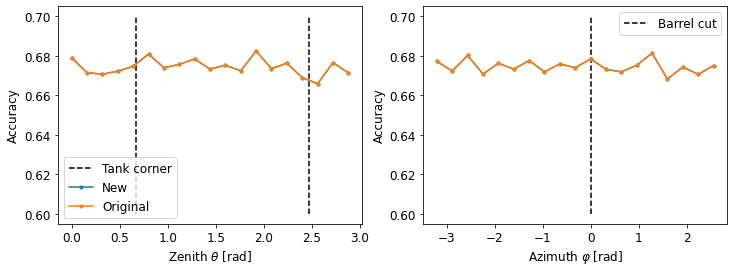

In [181]:
# Angles vs Accuracy

fig, axes = plt.subplots(ncols=2, figsize=(12,4))

bin_acc = df[['label','pred', 'zen_bins']].groupby('zen_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_acc = df[['label','bm_pred', 'zen_bins']].groupby('zen_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[0].errorbar(bin_acc[:,0], bin_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='New')#yerr=bin_uncertainty[:,1]
axes[0].errorbar(bin_bm_acc[:,0], bin_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Original')
#axes[0].set_ylim(0,1)
#axes[0].set_xticks(np.arange(0,1000,100))
axes[0].set_xlabel(r'Zenith $\theta$ [rad]')
axes[0].set_ylabel('Accuracy')
axes[0].vlines(0.67, ymin=0.6, ymax=0.7, label='Tank corner', linestyle='--', colors='black')
axes[0].vlines(2.47, ymin=0.6, ymax=0.7, linestyle='--', colors='black')
axes[0].legend()

bin_acc = df[['label','pred', 'azi_bins']].groupby('azi_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_acc = df[['label','bm_pred', 'azi_bins']].groupby('azi_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[1].errorbar(bin_acc[:,0], bin_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='New')#yerr=bin_uncertainty[:,1]
axes[1].errorbar(bin_bm_acc[:,0], bin_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Original')
#axes[1].set_ylim(0,1)
#axes[1].set_xticks(np.arange(-3,4,1))
axes[1].set_xlabel(r'Azimuth $\varphi$ [rad]')
axes[1].set_ylabel('Accuracy')
axes[1].vlines(0, ymin=0.6, ymax=0.7, label='Barrel cut', linestyle='--', colors='black')
axes[1].legend(['Barrel cut'])

plt.show()

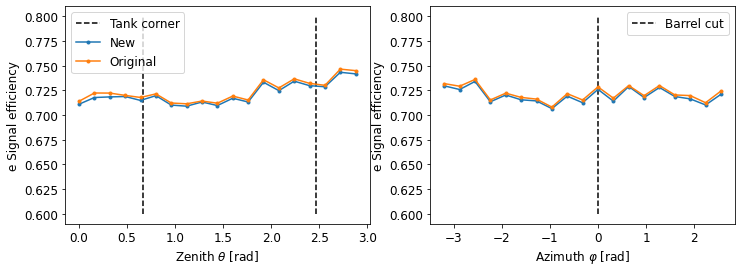

In [184]:
# Angles vs Eff

fig, axes = plt.subplots(ncols=2, figsize=(12,4))

bin_ese = df[['label','pred', 'zen_bins']].groupby('zen_bins').apply(lambda x: electron_signal_eff(x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_ese = df[['label','bm_pred', 'zen_bins']].groupby('zen_bins').apply(lambda x: electron_signal_eff(x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[0].errorbar(bin_ese[:,0], bin_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='New')#yerr=bin_uncertainty[:,1]
axes[0].errorbar(bin_bm_ese[:,0], bin_bm_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Original')
#axes[0].set_ylim(0,1)
#axes[0].set_xticks(np.arange(0,1000,100))
axes[0].set_xlabel(r'Zenith $\theta$ [rad]')
axes[0].set_ylabel('e Signal efficiency')
axes[0].vlines(0.67, ymin=0.6, ymax=0.8, label='Tank corner', linestyle='--', colors='black')
axes[0].vlines(2.47, ymin=0.6, ymax=0.8, linestyle='--', colors='black')
axes[0].legend()

bin_ese = df[['label','pred', 'azi_bins']].groupby('azi_bins').apply(lambda x: electron_signal_eff(x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_ese = df[['label','bm_pred', 'azi_bins']].groupby('azi_bins').apply(lambda x: electron_signal_eff(x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[1].errorbar(bin_ese[:,0], bin_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='New')#yerr=bin_uncertainty[:,1]
axes[1].errorbar(bin_bm_ese[:,0], bin_bm_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Original')
#axes[1].set_ylim(0,1)
#axes[1].set_xticks(np.arange(-3,4,1))
axes[1].set_xlabel(r'Azimuth $\varphi$ [rad]')
axes[1].set_ylabel('e Signal efficiency')
axes[1].vlines(0, ymin=0.6, ymax=0.8, label='Barrel cut', linestyle='--', colors='black')
axes[1].legend(['Barrel cut'])

plt.show()

In [ ]:
# Angles vs Uncertainty

bin_uncertainty_d1 = df[['uncertainty', 'zen_bins']].groupby('zen_bins').mean().reset_index().to_numpy()
bin_uncertainty_d2 = df[['uncertainty', 'azi_bins']].groupby('azi_bins').mean().reset_index().to_numpy()

fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].errorbar(bin_uncertainty_d1[:,0], bin_uncertainty_d1[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='New')#yerr=bin_uncertainty[:,1]
#axes[0].set_ylim(0,1)
#axes[0].set_xticks(np.arange(0,1000,100))
axes[0].set_xlabel(r'Zenith $\theta$ [rad]')
axes[0].set_ylabel('Uncertainty')
axes[0].vlines(0.67, ymin=0.2, ymax=0.4, label='Tank corner', linestyle='--', colors='black')
axes[0].vlines(2.47, ymin=0.2, ymax=0.4, linestyle='--', colors='black')
axes[0].legend()

axes[1].errorbar(bin_uncertainty_d2[:,0], bin_uncertainty_d2[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='New')#yerr=bin_uncertainty[:,1]
#axes[1].set_ylim(0,1)
#axes[1].set_xticks(np.arange(0,300,50))
axes[1].set_xlabel(r'Azimuth $\varphi$ [rad]')
axes[1].set_ylabel('Uncertainty')
axes[1].vlines(0, ymin=0.2, ymax=0.4, label='Barrel cut', linestyle='--', colors='black')
axes[1].legend(['Barrel cut'])

plt.show()

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
    await self.process_one()
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
    await dispatch(*args)
TypeError: object NoneType can't be used in 'await' expression

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/ipykernel_laun